# California Housing Prices

A model of housing prices in the state. The model should predict median housing price in any district, given all the metrics.

## 0. Framing the problem

* Supervised Learning (the data is labeled)
* Regression Task (predict median housing price)
    * Multiple regression (the data has multiples features)
    * Univariate regression (Single prediction for each entry)
    * plain batch learning (there is no data streaming or a big data problem)

### 0.1. Performance Measure
$$RMSE(X, h)=\sqrt{\frac{1}{m}\sum_{i=1}^m(h(X^i)-y^i)^2}$$

if the data has many outliers the $ RMSE $ is penalized because it is squared. In this case, $ MAE $ may be more suitable. 
$$MAE(X, h)=\frac{1}{m}\sum_{i=1}^m|h(X^i)-y^i|$$

## 1. Imports

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

## 2. Getting the data

In [2]:
download_root = "https://raw.githubusercontent.com/caiomts/handson-ml2/master/datasets/housing/housing.csv"

In [3]:
data = pd.read_csv(download_root)

In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 3. Exploring the data structure

In [19]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [21]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

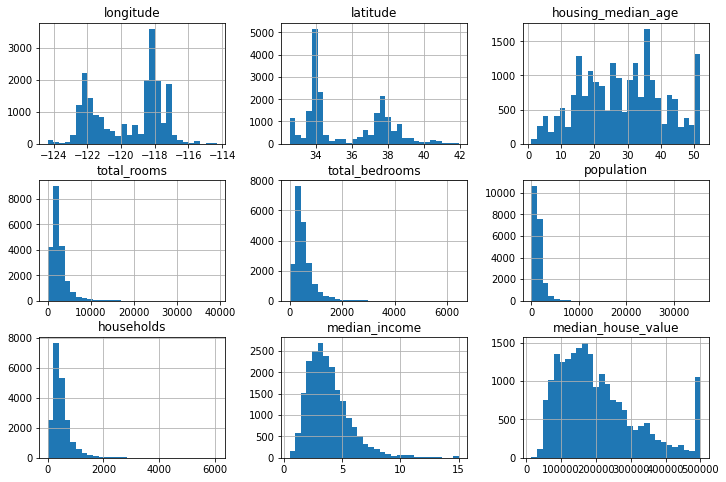

In [23]:
data.hist(bins=30, figsize=(12, 8))

* median_income is preprocessed, scaled and capped [0.5, 15]
* median_house_value is capped in 500,000
* housing_median_age is capped in 50

/home/caiomts/anaconda3/envs/infamous-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='median_house_value', ylabel='Density'>

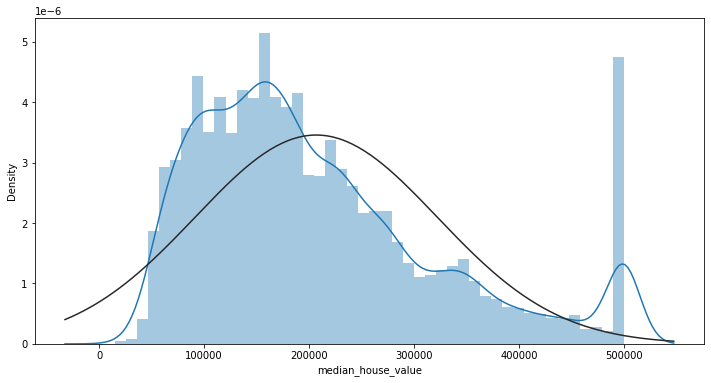

In [18]:
plt.figure(figsize=(12,6))
sns.distplot(housing['median_house_value'] , fit=norm)

<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>

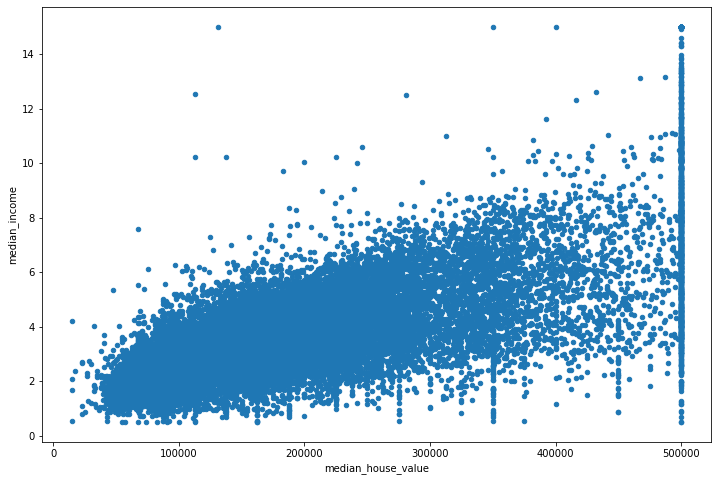

In [26]:
data.plot(kind='scatter', x='median_house_value', y='median_income', figsize=(12, 8))

/home/caiomts/anaconda3/envs/infamous-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='median_income', ylabel='Density'>

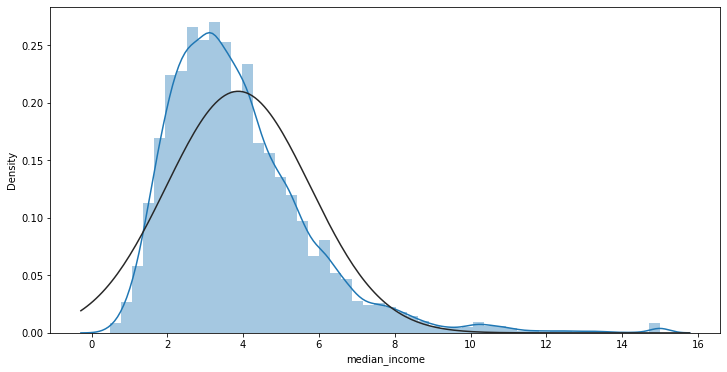

In [27]:
plt.figure(figsize=(12,6))
sns.distplot(housing['median_income'] , fit=norm)

## 4. Test Set

In [32]:
# avoiding sampling bias - stratified sampling
housing = data.copy()
housing['income_cat'] = pd.cut(housing['median_income'], bins=5)

In [34]:
housing['income_cat'].value_counts()

(0.485, 3.4]    9683
(3.4, 6.3]      9088
(6.3, 9.2]      1488
(9.2, 12.1]      271
(12.1, 15.0]     110
Name: income_cat, dtype: int64

In [36]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(housing, housing['income_cat']):
    train = housing.loc[train_index]
    test = housing.loc[test_index]

In [37]:
# drop income_cat
for data in (train, test):
    data.drop('income_cat', axis=1, inplace=True)

## 5. Exploring and Analysing the data (EDA)

In [38]:
housing = train.copy()

### 5.1. Taking a look at geographical data

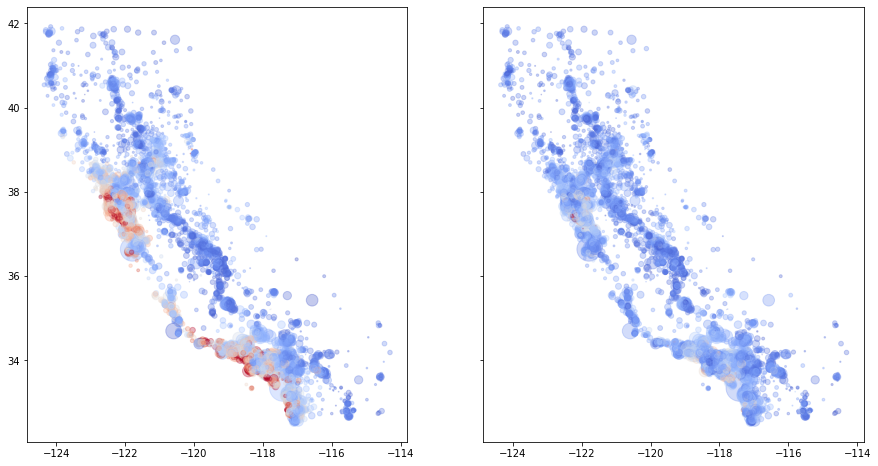

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 8))

ax[0].scatter(data= housing, x='longitude', y='latitude', alpha=0.3, 
              s=housing.population/50, label='population',
              c='median_house_value', cmap=plt.get_cmap('coolwarm'))

ax[1].scatter(data= housing, x='longitude', y='latitude', alpha=0.3,
                    s=housing.population/50, label='population',
                    c='median_income', cmap=plt.get_cmap('coolwarm'))

Housing prices are related to the location as well as to the population density and median income

### 5.2. Correlations

In [66]:
corr = housing.corr()
corr.sort_values(by=['median_house_value'], ascending=False)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
median_house_value,-0.049171,-0.143003,0.105963,0.134639,0.050426,-0.024760,0.066241,0.687750,1.000000
median_income,-0.018155,-0.077613,-0.116162,0.199191,-0.007480,0.005928,0.013836,1.000000,0.687750
total_rooms,0.043453,-0.036126,-0.357519,1.000000,0.929992,0.853380,0.918674,0.199191,0.134639
housing_median_age,-0.105912,0.007988,1.000000,-0.357519,-0.318403,-0.289969,-0.300555,-0.116162,0.105963
households,0.053271,-0.070518,-0.300555,0.918674,0.979652,0.904492,1.000000,0.013836,0.066241
total_bedrooms,0.068522,-0.067368,-0.318403,0.929992,1.000000,0.874536,0.979652,-0.007480,0.050426
population,0.096979,-0.106862,-0.289969,0.853380,0.874536,1.000000,0.904492,0.005928,-0.024760
longitude,1.000000,-0.923948,-0.105912,0.043453,0.068522,0.096979,0.053271,-0.018155,-0.049171
latitude,-0.923948,1.000000,0.007988,-0.036126,-0.067368,-0.106862,-0.070518,-0.077613,-0.143003


<AxesSubplot:>

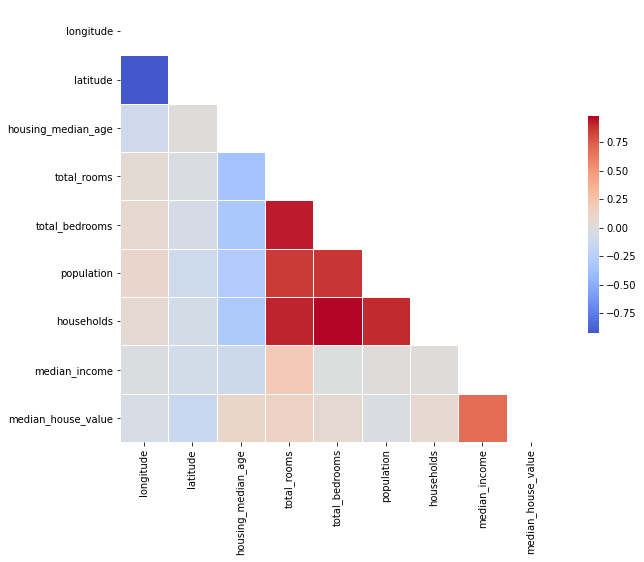

In [84]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=plt.get_cmap('coolwarm'), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

median_income is highly positively correlated with the target value. latitude is the second most correlated, but is negatively. More distance from the ocean the median value decreases. 
Household is highly correlated with total_room, total_bedroom and population. total_room with total bedroom

In [89]:
skewed = train.loc[:,train.columns != 'ocean_proximity'].apply(skew).sort_values(ascending=False)
skewed

population            5.330596
total_rooms           4.204341
households            3.351465
median_income         1.650456
median_house_value    0.980234
latitude              0.455123
housing_median_age    0.068404
longitude            -0.283194
total_bedrooms             NaN
dtype: float64